
--- Step 1: Loading Subset AnnData Objects and Images ---
  Attempting to load: rotated_split_tissue_h5ad/rotated_e14_spatial.h5ad
    Loaded 'rotated_e14_spatial.h5ad'. Shape: (62389, 19059)
      Checking loaded adata.X: dtype=float64, min=0.00, max=243.00
      Assigning Sample ID: e14
  Attempting to load: rotated_split_tissue_h5ad/rotated_e15_spatial.h5ad
    Loaded 'rotated_e15_spatial.h5ad'. Shape: (74479, 19059)
      Checking loaded adata.X: dtype=float64, min=0.00, max=263.00
      Assigning Sample ID: e15
  Attempting to load: rotated_split_tissue_h5ad/rotated_e16_spatial.h5ad
    Loaded 'rotated_e16_spatial.h5ad'. Shape: (78697, 19059)
      Checking loaded adata.X: dtype=float64, min=0.00, max=452.00
      Assigning Sample ID: e16

--- Step 2: Calculating Coordinate Offsets and Adjusting Coordinates ---
  Coordinate Offset for rotated_e14_spatial.h5ad: (0, 0)
  Coordinate Offset for rotated_e15_spatial.h5ad: (10633, 0)
  Coordinate Offset for rotated_e16_spatial.h5ad: (23

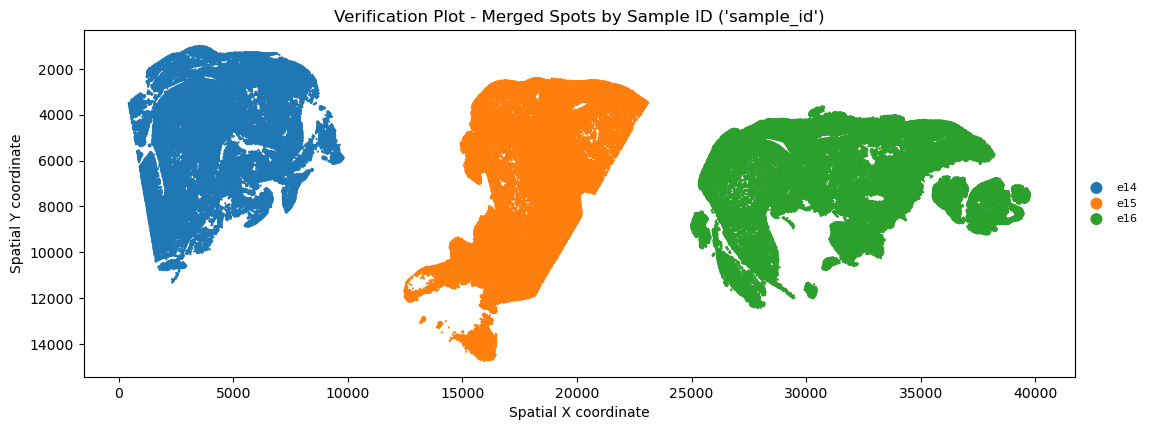


--- Spatial Merging Script Finished ---


In [6]:
# %% [markdown]
# # Merge RAW Spatial ROIs into a Single Spatial AnnData File & Export Image
#
# This notebook loads individual spatial ROI subset AnnData files (assumed to contain RAW counts),
# extracts a sample identifier (e.g., 'e14', 'e15') from the filename, adds this identifier
# to the observation metadata (`.obs`), stitches their images together horizontally onto a new canvas,
# adjusts the spot coordinates accordingly, combines the RAW expression data,
# and saves a new, single AnnData object with combined spatial information, sample IDs,
# the stitched canvas image as a separate file, and a CSV mapping of cell IDs to sample IDs.
#
# **NO additional QC, normalization, or processing is applied during this merge.**

# %%
# --- Imports ---
import anndata as ad
import scanpy as sc # Still needed for pl.scatter if used in verification
import os
import re # Needed for extracting sample ID
import numpy as np
import cv2 # Need OpenCV for image manipulation
import traceback
import pandas as pd
from scipy.sparse import issparse, vstack as sparse_vstack, csr_matrix # For stacking sparse matrices
import matplotlib.pyplot as plt # For saving image and plotting
# import matplotlib.ticker as mticker # Not needed if only plotting spots

# --- Configuration (Adjust these paths/names if needed) ---
# Directory where the individual ROI subset files are saved
# >>> IMPORTANT: These files should contain RAW COUNTS in .X <<<
subset_output_dir = "rotated_split_tissue_h5ad" # Or "split_tissue_h5ad" depending on previous script

# The prefix used for the subset filenames (e.g., "roi_pct_", "eX_")
# >>> Adjust prefix if necessary to match your subset filenames <<<
subset_output_prefix = "rotated_" # Or e.g., "e" if filenames are e13_spatial.h5ad

# List the *original* base filenames or the *exact* subset filenames
# This defines the order of stitching (left-to-right)
# Option 1: Using original base names (if prefix is consistent)
# original_base_filenames = [
#     "rotated_e14_spatial.h5ad",
#     "rotated_e15_spatial.h5ad",
#     "rotated_e16_spatial.h5ad",
# ]
# Make sure subset_output_prefix + base_filename matches the actual files.

# Option 2: Listing exact subset filenames (more robust if names vary)
# Make sure these filenames exist in subset_output_dir
subset_filenames_ordered = [
    "rotated_e14_spatial.h5ad", # <<< Replace with your actual filenames in order
    "rotated_e15_spatial.h5ad",
    "rotated_e16_spatial.h5ad",
]


# --- Output Configuration ---
# Directory to save the final merged spatial file and the exported image
merged_output_dir = "merged_shoulder_spatial_h5ad"
merged_anndata_filename = "merged_shoulder_spatial_rois_RAW.h5ad" # Indicate RAW in name
merged_image_filename = "merged_shoulder_spatial_rois_image.png" # Choose PNG or TIF(F)
# >>> NEW: Output filename for the Cell ID <-> Sample ID mapping <<<
mapping_csv_filename = "merged_shoulder_cell_sample_mapping.csv"

merged_anndata_path = os.path.join(merged_output_dir, merged_anndata_filename)
merged_image_path = os.path.join(merged_output_dir, merged_image_filename)
# >>> NEW: Full path for the mapping CSV <<<
mapping_csv_path = os.path.join(merged_output_dir, mapping_csv_filename)


# Optional: Add padding between stitched images (in pixels)
padding = 50
canvas_background_color = (255, 255, 255) # White background (RGB)

# --- Create Output Directory ---
os.makedirs(merged_output_dir, exist_ok=True)

# --- Step 1: Load Subset AnnData Objects and Images ---
print("\n--- Step 1: Loading Subset AnnData Objects and Images ---")
adata_objects = {}
images = {}
scalefactors_dict = {}
original_metadata = {}
loaded_filenames_ordered = [] # Store names of files actually loaded in desired order
all_obs_list = []
all_coords_list = [] # Coordinates collected in Step 2
all_X_list = []

# Use the explicit list of subset filenames
for subset_filename in subset_filenames_ordered:
    subset_file_path = os.path.join(subset_output_dir, subset_filename)
    print(f"  Attempting to load: {subset_file_path}")
    if os.path.exists(subset_file_path):
        try:
            # Load AnnData - ASSUMES .X IS RAW COUNTS
            adata_sub = ad.read_h5ad(subset_file_path)
            print(f"    Loaded '{subset_filename}'. Shape: {adata_sub.shape}")
            print(f"      Checking loaded adata.X: dtype={adata_sub.X.dtype}, min={adata_sub.X.min():.2f}, max={adata_sub.X.max():.2f}")

            adata_objects[subset_filename] = adata_sub
            loaded_filenames_ordered.append(subset_filename)

            # Extract necessary spatial info
            if 'spatial' not in adata_sub.uns or not adata_sub.uns['spatial']: raise KeyError(".uns['spatial'] missing/empty.")
            library_id = list(adata_sub.uns['spatial'].keys())[0]
            if 'images' not in adata_sub.uns['spatial'][library_id] or 'hires' not in adata_sub.uns['spatial'][library_id]['images']: raise KeyError("hires image missing.")
            images[subset_filename] = adata_sub.uns['spatial'][library_id]['images']['hires']
            if not scalefactors_dict: scalefactors_dict = adata_sub.uns['spatial'][library_id].get('scalefactors', {}).copy() # Get scalefactors safely
            original_metadata[subset_filename] = adata_sub.uns['spatial'][library_id].get('metadata', {})
            if 'spatial' not in adata_sub.obsm: raise KeyError(".obsm['spatial'] missing.")

            # --- Prepare for merge (unique names, sample ID) ---
            match = re.search(r'(e\d+)', subset_filename)
            sample_id = match.group(1) if match else subset_filename.replace(".h5ad", "").replace(subset_output_prefix, "") # Fallback
            print(f"      Assigning Sample ID: {sample_id}")

            adata_sub.obs_names = f"{sample_id}_" + adata_sub.obs_names.astype(str)
            adata_sub.obs_names_make_unique()

            adata_sub.obs['sample_id'] = sample_id
            adata_sub.obs['sample_id'] = adata_sub.obs['sample_id'].astype('category')

            adata_sub.var_names_make_unique()

            all_obs_list.append(adata_sub.obs.copy())
            all_X_list.append(adata_sub.X)

        except Exception as e: print(f"    Error loading or processing {subset_filename}: {e}"); traceback.print_exc()
    else: print(f"    Warning: Subset file not found: {subset_file_path}")

if not adata_objects: print("\nError: No subset AnnData objects loaded. Cannot proceed."); exit()
if not scalefactors_dict: print("\nWarning: No scalefactors found in loaded subsets. Using defaults if needed.")


# --- Step 2: Calculate Coordinate Offsets and Adjust Coordinates ---
print("\n--- Step 2: Calculating Coordinate Offsets and Adjusting Coordinates ---")
current_x_offset = 0
num_loaded_images = len(loaded_filenames_ordered)
for i, subset_filename in enumerate(loaded_filenames_ordered):
     adata_sub = adata_objects[subset_filename]
     img_width = images[subset_filename].shape[1]
     y_offset = 0

     print(f"  Coordinate Offset for {subset_filename}: ({current_x_offset}, {y_offset})")
     original_coords = adata_sub.obsm['spatial']
     if not isinstance(original_coords, np.ndarray):
         original_coords = original_coords.to_numpy()

     adjusted_coords = original_coords.copy() + np.array([current_x_offset, y_offset])
     all_coords_list.append(adjusted_coords)

     if i < num_loaded_images - 1:
        current_x_offset += img_width + padding


# --- Step 3: Create Stitched Image Canvas ---
print("\n--- Step 3: Creating stitched image canvas ---")
total_width = 0
if loaded_filenames_ordered:
     for i, subset_filename in enumerate(loaded_filenames_ordered):
          img_width = images[subset_filename].shape[1]
          total_width += img_width
          if i < num_loaded_images - 1: total_width += padding
else:
     print("No images loaded to stitch.")

max_height = 0
if images: max_height = max(img.shape[0] for img in images.values())

print(f"  Canvas Dimensions (H x W): {max_height} x {total_width}")
canvas = np.full((max_height, total_width, 3), canvas_background_color, dtype=np.uint8) if max_height > 0 and total_width > 0 else None

current_x_placement_offset = 0
if canvas is not None:
    for i, subset_filename in enumerate(loaded_filenames_ordered):
        img = images[subset_filename]; h, w = img.shape[:2]; y_offset_place = 0
        print(f"  Placing '{subset_filename}' at canvas X offset: {current_x_placement_offset}")
        # Image conversion logic...
        if img.dtype != np.uint8:
            print(f"    Warning: Converting image for {subset_filename} from {img.dtype} to uint8.")
            img = img.astype(np.float32)
            img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255.0
            img = img.astype(np.uint8)

        if img.ndim == 2: img_to_place = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 4: img_to_place = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
        elif img.shape[2] == 3: img_to_place = img
        else:
             print(f"    ERROR: Unsupported image channel count ({img.shape}) for {subset_filename}. Skipping placement.")
             continue

        x_start, x_end = current_x_placement_offset, current_x_placement_offset + w
        y_start, y_end = y_offset_place, y_offset_place + h
        if x_end <= canvas.shape[1] and y_end <= canvas.shape[0]:
            canvas[y_start:y_end, x_start:x_end, :] = img_to_place
        else: print(f"    ERROR: Slice out of bounds. Skipping placement.")

        if i < num_loaded_images - 1: current_x_placement_offset += w + padding
    print("  Image stitching complete.")
    print(f"    Canvas Check (After Stitch): dtype={canvas.dtype}, min={np.min(canvas)}, max={np.max(canvas)}")
else: print("  Canvas creation skipped.")


# --- Step 4: Combine Data and Create Merged AnnData ---
print("\n--- Step 4: Combining data and creating merged AnnData ---")

# Combine Observations
combined_obs = pd.concat(all_obs_list, axis=0, ignore_index=False) if all_obs_list else None
if combined_obs is not None:
    print(f"  Combined obs shape: {combined_obs.shape}")
    if 'sample_id' in combined_obs.columns:
        print(f"  Sample IDs found in combined obs: {combined_obs['sample_id'].unique().tolist()}")
    else:
        print("  WARNING: 'sample_id' column missing from combined obs!")
else: print("  ERROR: Failed to combine obs.")

# Combine Coordinates
combined_coords = np.vstack(all_coords_list) if all_coords_list else None
if combined_coords is not None: print(f"  Combined coords shape: {combined_coords.shape}")
else: print("  ERROR: Failed to combine coords.")

# Combine Expression Matrices
combined_X = None
if all_X_list:
     try:
          is_sparse = any(issparse(m) for m in all_X_list)
          print(f"    Attempting X combination for {len(all_X_list)} matrices (Sparse={is_sparse})...")
          matrices_to_stack = []
          for m in all_X_list:
              if m is None: continue
              if issparse(m): matrices_to_stack.append(m.tocsr())
              elif isinstance(m, np.ndarray): matrices_to_stack.append(csr_matrix(m))
              else: raise TypeError(f"Unsupported matrix type: {type(m)}")

          if matrices_to_stack:
             combined_X = sparse_vstack(matrices_to_stack, format='csr')
             print(f"    Combined X shape: {combined_X.shape}")
          else: combined_X = None

     except Exception as e: print(f"ERROR Combining X: {e}"); traceback.print_exc(); combined_X = None
else: print("  ERROR: No X matrices collected.")

# Get Variable annotations
combined_var = None
if loaded_filenames_ordered and loaded_filenames_ordered[0] in adata_objects:
     try:
          first_key = loaded_filenames_ordered[0]
          combined_var = adata_objects[first_key].var.copy()
          combined_var.index.name = None
          combined_var.index = ad.utils.make_index_unique(combined_var.index.astype(str))
          print(f"  Using variable annotations from '{first_key}'. Var shape: {combined_var.shape}")
     except Exception as e: print(f"ERROR getting var: {e}"); combined_var = None
else: print("  ERROR: Cannot get var annotations.")

# Create Merged AnnData
adata_merged_spatial = None
if combined_X is not None and combined_obs is not None and combined_var is not None and combined_coords is not None and canvas is not None and scalefactors_dict:
    print("\n  Creating final AnnData object with RAW counts in .X ...")
    try:
        n_obs_X, n_vars_X = combined_X.shape
        n_obs_obs = combined_obs.shape[0]
        n_vars_var = combined_var.shape[0]
        n_obs_coords = combined_coords.shape[0]
        print(f"    Shape check: X=({n_obs_X},{n_vars_X}), obs=({n_obs_obs}, ...), var=({n_vars_var}, ...), coords=({n_obs_coords}, ...)")
        if not (n_obs_X == n_obs_obs == n_obs_coords): raise ValueError(f"Inconsistent observations: X={n_obs_X}, obs={n_obs_obs}, coords={n_obs_coords}")
        if not (n_vars_X == n_vars_var): raise ValueError(f"Inconsistent variables: X={n_vars_X}, var={n_vars_var}")

        adata_merged_spatial = ad.AnnData(X=combined_X, obs=combined_obs, var=combined_var, obsm={'spatial': combined_coords})
        print(f"    AnnData object created. Shape: {adata_merged_spatial.shape}")

        merged_library_id = "stitched_rois_raw"
        adata_merged_spatial.uns['spatial'] = {}
        adata_merged_spatial.uns['spatial'][merged_library_id] = {
            'images': {'hires': canvas},
            'scalefactors': scalefactors_dict,
            'metadata': {
                'comment': 'Merged spatial ROIs (RAW counts) via horizontal stitching.',
                'padding_pixels': padding,
                'original_files_metadata': original_metadata
             }
        }
        print("    uns['spatial'] structure created.")
        final_image = adata_merged_spatial.uns['spatial'][merged_library_id]['images']['hires']
        print(f"    Final Image Check: dtype={final_image.dtype}, min={np.min(final_image)}, max={np.max(final_image)}")

    except Exception as e:
        print(f"\nERROR: Failed to create/finalize AnnData object: {e}"); traceback.print_exc()
        adata_merged_spatial = None
else:
    print("\nERROR: One or more required components missing/failed. Cannot create merged AnnData.")
    print(f"  Status: combined_X={'OK' if combined_X is not None else 'FAIL'}, "
          f"combined_obs={'OK' if combined_obs is not None else 'FAIL'}, "
          f"combined_var={'OK' if combined_var is not None else 'FAIL'}, "
          f"combined_coords={'OK' if combined_coords is not None else 'FAIL'}, "
          f"canvas={'OK' if canvas is not None else 'FAIL'}, "
          f"scalefactors_dict={'OK' if scalefactors_dict else 'FAIL'}")


# --- Step 5: Save Merged Spatial AnnData, Export Image, and Export Mapping ---

# 5a: Save AnnData
if adata_merged_spatial is not None:
    print("\n--- Step 5a: Saving merged spatial AnnData (RAW counts in .X) ---")
    try:
        adata_merged_spatial.write(merged_anndata_path, compression="gzip")
        print(f"  Successfully saved merged AnnData to: {merged_anndata_path}")
    except Exception as e:
        print(f"  Error saving merged AnnData: {e}"); traceback.print_exc()
else:
     print("\n--- Step 5a: Skipping AnnData save (object not created) ---")

# 5b: Export image
if canvas is not None:
     print("\n--- Step 5b: Exporting stitched canvas image ---")
     try:
        plt.imsave(merged_image_path, canvas)
        print(f"  Successfully exported stitched image to: {merged_image_path}")
     except Exception as save_e:
        print(f"  Error exporting image using matplotlib: {save_e}"); traceback.print_exc()
        try:
            print("    Attempting fallback save with OpenCV...")
            success = cv2.imwrite(merged_image_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
            if success: print(f"  Successfully exported stitched image using OpenCV to: {merged_image_path}")
            else: print(f"  OpenCV fallback save also failed.")
        except Exception as cv_e: print(f"  Error during OpenCV fallback save: {cv_e}")
else:
     print("\n--- Step 5b: Skipping image export (canvas not created) ---")

# >>> NEW: Step 5c: Export Cell ID to Sample ID mapping <<<
if adata_merged_spatial is not None and 'sample_id' in adata_merged_spatial.obs:
    print("\n--- Step 5c: Exporting Cell ID to Sample ID mapping ---")
    try:
        # Create a DataFrame with cell IDs (obs_names) and sample IDs
        mapping_df = pd.DataFrame({
            'cell_id': adata_merged_spatial.obs_names,
            'sample_id': adata_merged_spatial.obs['sample_id']
        })
        # Save to CSV without the DataFrame index
        mapping_df.to_csv(mapping_csv_path, index=False, sep=',')
        print(f"  Successfully exported cell/sample mapping to: {mapping_csv_path}")
        print(f"    Mapping file shape: {mapping_df.shape}")
        print(f"    Mapping file head:\n{mapping_df.head().to_string()}") # Show first few lines
    except Exception as e:
        print(f"  Error exporting cell/sample mapping: {e}"); traceback.print_exc()
elif adata_merged_spatial is None:
     print("\n--- Step 5c: Skipping mapping export (AnnData object not created) ---")
else: # AnnData exists but sample_id column is missing
     print("\n--- Step 5c: Skipping mapping export ('sample_id' column not found in AnnData .obs) ---")


# --- Step 6: Optional Verification Plot (Spots Only Recommended) ---
print("\n--- Step 6: Optional Verification Plot (Spots Only) ---")
if os.path.exists(merged_anndata_path):
    try:
        print(f"  Loading merged spatial data from: {merged_anndata_path}")
        adata_plot = ad.read_h5ad(merged_anndata_path)
        print(f"    Loaded AnnData shape for plot: {adata_plot.shape}")
        print(f"    Available .obs columns: {adata_plot.obs.columns.tolist()}")

        if 'spatial' not in adata_plot.obsm: raise KeyError(".obsm['spatial'] not found.")
        if 'sample_id' not in adata_plot.obs: raise KeyError(".obs['sample_id'] not found. Cannot color by sample.")

        coords_plot = adata_plot.obsm['spatial']
        adata_plot.obs['spatial_x'] = coords_plot[:, 0]
        adata_plot.obs['spatial_y'] = coords_plot[:, 1]

        color_variable = 'sample_id'
        print(f"    Using '{color_variable}' for spot colors.")
        print(f"    Unique values in '{color_variable}': {adata_plot.obs[color_variable].unique().tolist()}")

        fig_verify, ax_verify = plt.subplots(figsize=(14, 8))

        print("    Plotting spots using pl.scatter (no background image)...")
        spot_size_pixels = 10
        scatter_params = {
            'adata': adata_plot, 'x': 'spatial_x', 'y': 'spatial_y',
            'color': color_variable, 'ax': ax_verify, 'show': False,
            'title': "",
            'size': spot_size_pixels,
            'legend_loc': 'right margin',
            'legend_fontsize': 8
        }
        sc.pl.scatter(**scatter_params)

        ax_verify.invert_yaxis()
        ax_verify.set_aspect('equal', adjustable='box')

        ax_verify.set_xlabel("Spatial X coordinate")
        ax_verify.set_ylabel("Spatial Y coordinate")
        ax_verify.set_title(f"Verification Plot - Merged Spots by Sample ID ('{color_variable}')", fontsize=12)

        legend_margin = 0.85
        fig_verify.tight_layout(rect=[0.02, 0.03, legend_margin, 0.97])

        plt.show()
        del adata_plot

    except Exception as e: print(f"  Error generating verification plot: {e}"); traceback.print_exc()
else: print("  Merged AnnData file not found, skipping verification plot.")

print("\n--- Spatial Merging Script Finished ---")

In [7]:
# 加载数据
roi_adata = ad.read_h5ad("./merged_shoulder_spatial_h5ad/merged_shoulder_spatial_rois_RAW.h5ad")
roi_adata

AnnData object with n_obs × n_vars = 215565 × 19059
    obs: 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'geometry_wkt', 'area', 'tissue_section_id', 'sample_id'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

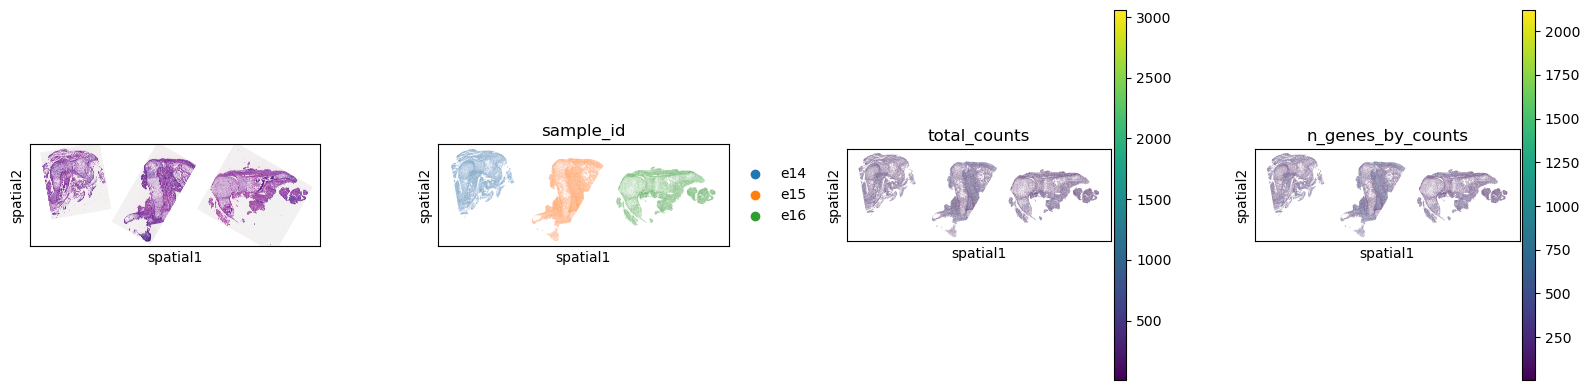

In [10]:
# 可视化验证
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
sc.pl.spatial(roi_adata, ax=axes[0], 
              show=False)
sc.pl.spatial(roi_adata, ax=axes[1], 
              color=['sample_id'],
              img_key = None,
              #spot_size=1,
              show=False)
sc.pl.spatial(roi_adata, ax=axes[2], 
              color=["total_counts"],
              img_key = None,
              show=False)
sc.pl.spatial(roi_adata, ax=axes[3], 
              color=['n_genes_by_counts'],
              img_key = None,
              #spot_size=1,
              show=False)
plt.tight_layout()
plt.tight_layout()

plt.show()

In [11]:
plt.savefig("./merged_shoulder_spatial_h5ad/spatial_plots.tiff", bbox_inches='tight', dpi=300) # Saves

<Figure size 640x480 with 0 Axes>

In [ ]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)